## 1 导入相关包

In [3]:
import torch.nn.functional as F
import math
import torch
from nltk.tokenize import word_tokenize
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import copy
import numpy as np
import os
import re
import sacrebleu
import random
import time
import jieba
from nltk.tokenize.treebank import TreebankWordDetokenizer

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # 下面老是报错 shape 不一致

## 2 定义dataset类
用于传入dataloader

In [4]:
class TranslationDataset(Dataset):
    # 创建数据集
    def __init__(self, src, tgt):
        """
        初始化
        :param src: 源数据(经tokenizer处理后)
        :param tgt: 目标数据(经tokenizer处理后)
        """
        self.src = src
        self.tgt = tgt

    def __getitem__(self, i):
        return self.src[i], self.tgt[i]

    def __len__(self):
        return len(self.src)

## 3 定义tokenizer类
其作用是读取源数据并将其处理成可供模型输入的数据

In [5]:
class Tokenizer():
    ## 定义tokenizer,对原始数据进行处理
    def __init__(self, en_path, ch_path, count_min=5):
        """
        初始化
        :param en_path: 英文数据路径
        :param ch_path: 中文数据路径
        :param count_min: 对出现次数少于这个次数的数据进行过滤
        """
        self.en_path = en_path  # 英文路径
        self.ch_path = ch_path  # 中文路径
        self.__count_min = count_min  # 对出现次数少于这个次数的数据进行过滤

        # 读取原始英文数据
        self.en_data = self.__read_ori_data(en_path)
        # 读取原始中文数据
        self.ch_data = self.__read_ori_data(ch_path)

        self.index_2_word = ['unK', '<pad>', '<bos>', '<eos>']
        self.word_2_index = {'unK': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}

        self.en_set = set()
        self.en_count = {}

        # 中英文字符计数
        self.__en_count = {}
        self.__ch_count = {}

        self.__count_word()
        self.mx_length = 40
        # 创建英文词汇表
        self.data_ = []
        self.__filter_data()
        random.shuffle(self.data_)
        self.test = self.data_[-1000:]
        self.data_ = self.data_[:-1000]

    def __read_ori_data(self, path):
        """
        读取原始数据
        :param path: 数据路径
        :return: 返回一个列表，每个元素是一条数据
        """
        with open(path, 'r', encoding='utf-8') as f:
            data = f.read().split('\n')[:-1]
        return data

    def __count_word(self):
        """
        统计中英文词汇表
        :return:
        """
        le = len(self.en_data)
        p = 0
        # 统计英文词汇表
        for data in self.en_data:
            if p % 1000 == 0:
                print('英文', p / le)
            sentence = word_tokenize(data)
            for sen in sentence:
#                 sen=sen.lower()
                if sen in self.en_set:
                    self.en_count[sen] += 1
                else:
                    self.en_set.add(sen)
                    self.en_count[sen] = 1
            p += 1
        for k, v in self.en_count.items():
            if v >= self.__count_min:
                self.word_2_index[k] = len(self.index_2_word)
                self.index_2_word.append(k)
            else:
                self.word_2_index[k] = 0
        self.en_set = set()
        self.en_count = {}
        p = 0
        # 统计中文词汇表
        for data in self.ch_data:
            if p % 1000 == 0:
                print('中文', p / le)
            sentence = list(jieba.cut(data))
            for sen in sentence:
                if sen in self.en_set:
                    self.en_count[sen] += 1
                else:
                    self.en_set.add(sen)
                    self.en_count[sen] = 1
            p += 1
        # 构建词汇表
        for k, v in self.en_count.items():
            if v >= self.__count_min:
                self.word_2_index[k] = len(self.index_2_word)
                self.index_2_word.append(k)
            else:
                self.word_2_index[k] = 0

    def __filter_data(self):
        length = len(self.en_data)
        for i in range(length):
            # 0 代表英文到中文，1 代表中文到英文
            self.data_.append([self.en_data[i], self.ch_data[i], 0])
            self.data_.append([self.ch_data[i], self.en_data[i], 1])

    def en_cut(self, data):
        data = word_tokenize(data)
        # 用于存放每个句子对应的编码
        if len(data) > self.mx_length:
            return 0, []
        en_tokens = []
        # 对分词结果进行遍历
        for tk in data:
#             x = tk.lower()
            # 对于结果进行编码,0代表unK
            en_tokens.append(self.word_2_index.get(tk, 0))
        return 1, en_tokens

    def ch_cut(self, data):
        data = list(jieba.cut(data))
#         list(data)[:-1]
        # 用于存放每个句子对应的编码
        if len(data) > self.mx_length:
            return 0, []
        en_tokens = []
        # 对分词结果进行遍历
        for tk in data:
            # 对于结果进行编码,0代表unK
            en_tokens.append(self.word_2_index.get(tk, 0))
        return 1, en_tokens

    def encode_all(self, data):
        """
        对一组数据进行编码
        :param data: data是一个数组，形状为n*3 每个元素是[src_sentence, tgt_sentence, label]，label 0 代表英文到中文，1 代表中文到英文
        :return:
        """
        src = []
        tgt = []
        en_src, en_tgt, l = [], [], []
        labels=[]
        for i in data:
            en_src.append(i[0])
            en_tgt.append(i[1])
            l.append(i[2])
        for i in range(len(l)):
            if l[i] == 0:
                lab1, src_tokens = self.en_cut(en_src[i])
                if lab1 == 0:
                    continue
                lab2, tgt_tokens = self.ch_cut(en_tgt[i])
                if lab2 == 0:
                    continue
                src.append(src_tokens)
                tgt.append(tgt_tokens)
                labels.append(i)
            else:
                lab1, tgt_tokens = self.en_cut(en_tgt[i])
                if lab1 == 0:
                    continue
                lab2, src_tokens = self.ch_cut(en_src[i])
                if lab2 == 0:
                    continue
                src.append(src_tokens)
                tgt.append(tgt_tokens)
                labels.append(i)
        return labels,src, tgt

    def encode(self, src, l):
        if l == 0:
            src1 = word_tokenize(src)
            # 用于存放每个句子对应的编码
            en_tokens = []
            # 对分词结果进行遍历
            for tk in src1:
#                 x = tk.lower()
                # 对于结果进行编码
                en_tokens.append(self.word_2_index.get(tk, 0))
            return [en_tokens]
        else:
            src1 = list(jieba.cut(src))
            # 用于存放每个句子对应的编码
            en_tokens = []
            # 对分词结果进行遍历
            for tk in src1:
                # 对于结果进行编码
                en_tokens.append(self.word_2_index.get(tk, 0))
            return [en_tokens]

    def decode(self, data):
        """
        数据解码
        :param data: 这里传入一个中文的index
        :return: 返回解码后的一个字符
        """
        return self.index_2_word[data]

    def __get_datasets(self, data):
        """
        获取数据集
        :return:返回DataSet类型的数据 或者 None
        """
        # 将数据编码并
        labels,src, tgt = self.encode_all(data)
        # 返回数据集
        return TranslationDataset(src, tgt)

    def another_process(self, batch_datas):
        """
        特殊处理，这里传入一个batch的数据，并对这个batch的数据进行填充，使得每一行的数据长度相同。这里填充pad 空字符  bos 开始  eos结束
        :param batch_datas: 一个batch的数据
        :return: 返回填充后的数据
        """
        # 创建四个空字典存储数据
        en_index, ch_index = [], []  # 中文英文索引，中文索引
        en_len, ch_len = [], []  # 没行英文长度，每行中文长度

        for en, ch in batch_datas:  # 对batch进行遍历，将所有数据的索引与长度加入四个列表
            en_index.append(en)
            ch_index.append(ch)
            en_len.append(len(en))
            ch_len.append(len(ch))

        # 获取中英文的最大长度，根据这个长度对所有数据进行填充，使每行数据长度相同
        max_en_len = max(en_len)
        max_ch_len = max(ch_len)
        max_len = max(max_en_len, max_ch_len + 2)

        # 英文数据填充，i是原始数据，后面是填充的pad
        en_index = [i + [self.word_2_index['<pad>']] * (max_len - len(i)) for i in en_index]
        # 中文数据填充 先填充bos表示句子开始，后面接原始数据，最后填充eos表示句子结束，后面接pad
        ch_index = [[self.word_2_index['<bos>']] + i + [self.word_2_index['<eos>']] +
                    [self.word_2_index['<pad>']] * (max_len - len(i) + 1) for i in ch_index]

        # 将处理后的数据转换为tensor并放到相应设备上
        en_index = torch.tensor(en_index)
        ch_index = torch.tensor(ch_index)
        return en_index, ch_index

    def get_dataloader(self, data, batch_size=40):
        """
        获取dataloader
        :return:
        """
        # 获取数据集
        data = self.__get_datasets(data)
        # 返回DataLoader类型的数据
        return DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=self.another_process)

    # 获取英文词表大小
    def get_vocab_size(self):
        return len(self.index_2_word)

    # 获取数据集大小
    def get_dataset_size(self):
        return len(self.en_data)

## 4 定义batch类
其作用是生成掩码与统计非填充字符数

In [6]:
class Batch:
    # 批次类,对每一个批次的数据进行掩码生成操作
    def __init__(self, src, trg=None, tokenizer=None, device='cuda'):
        """
        初始化函数
        :param src: 源数据
        :param trg: 目标数据
        :param tokenizer: 分词器
        :param device: 训练设备
        """
        # 将输入、输出单词id表示的数据规范成整数类型并转换到训练设备上
        src = src.to(device).long()
        trg = trg.to(device).long()
        self.src = src  # 源数据 (batch, seq_len)
        self.__pad = tokenizer.word_2_index['<pad>']  # 填充字符的索引
        # 对于当前输入的语句非空部分进行判断，这里是对源数据进行掩码操作，将填充的内容置为0
        # 并在seq length前面增加一维，形成维度为 1×seq length 的矩阵
        self.src_mask = (src != self.__pad).unsqueeze(-2)
        # 如果输出目标不为空，则需要对解码器使用的目标语句进行掩码
        if trg is not None:
            # 解码器使用的目标输入部分
            self.trg = trg[:, : -1]
            # 解码器训练时应预测输出的目标结果
            self.trg_y = trg[:, 1:]
            # 将目标输入部分进行注意力掩码
            self.trg_mask = self.make_std_mask(self.trg, self.__pad)
            # 将应输出的目标结果中实际的词数进行统计
            self.ntokens = (self.trg_y != self.__pad).data.sum()

    # 掩码操作
    @staticmethod
    def make_std_mask(tgt, pad):
        """
        生成掩码矩阵
        :param tgt: 目标数据
        :param pad: 填充字符的索引
        :return:
        """
        tgt_mask = (tgt != pad).unsqueeze(-2)  # 首先对pad进行掩码生成
        # 这里对注意力进行掩码操作并与pad掩码结合起来。
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

#### 注意力掩码生成函数

In [7]:
def subsequent_mask(size):
    """
    注意力机制掩码生成
    :param size: 句子长度
    :return: 注意力掩码
    """
    # 设定subsequent_mask矩阵的shape
    attn_shape = (1, size, size)
    # 生成一个右上角(不含主对角线)为全1，左下角(含主对角线)为全0的subsequent_mask矩阵
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    # 返回一个右上角(不含主对角线)为全False，左下角(含主对角线)为全True的subsequent_mask矩阵
    return torch.from_numpy(subsequent_mask) == 0


## 5 词嵌入类

In [8]:
class Embedding(nn.Module):
    # 词嵌入层
    def __init__(self, d_model, vocab):
        """
        词嵌入层初始化
        :param d_model: 词嵌入维度
        :param vocab: 词表大小
        """
        super(Embedding, self).__init__()
        # Embedding层
        self.lut = nn.Embedding(vocab, d_model)
        # Embedding维数
        self.d_model = d_model

    def forward(self, x):
        # 返回x的词向量（需要乘以math.sqrt(d_model)）
        return self.lut(x) * math.sqrt(self.d_model)

## 6 位置编码器类

In [9]:
class PositionalEncoding(nn.Module):
    # 位置编码器层
    def __init__(self, d_model, dropout=0.1, max_len=5000, device='cuda'):
        """
        位置编码器层初始化
        :param d_model: 词嵌入维度
        :param dropout: dropout比例
        :param max_len: 序列最大长度
        :param device: 训练设备
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # 位置编码矩阵，维度[max_len, embedding_dim]
        pe = torch.zeros(max_len, d_model, device=device)
        # 单词位置
        position = torch.arange(0.0, max_len, device=device)
        position.unsqueeze_(1)
        # 使用exp和log实现幂运算
        div_term = torch.exp(torch.arange(0.0, d_model, 2, device=device) * (- math.log(1e4) / d_model))
        div_term.unsqueeze_(0)
        # 计算单词位置沿词向量维度的纹理值
        pe[:, 0:: 2] = torch.sin(torch.mm(position, div_term))
        pe[:, 1:: 2] = torch.cos(torch.mm(position, div_term))
        # 增加批次维度，[1, max_len, embedding_dim]
        pe.unsqueeze_(0)
        # 将位置编码矩阵注册为buffer(不参加训练)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # 将一个批次中语句所有词向量与位置编码相加
        # 注意，位置编码不参与训练，因此设置requires_grad=False
        x += Variable(self.pe[:, : x.size(1), :], requires_grad=False)
        return self.dropout(x)

## 7 多头注意力机制类

In [10]:
class MultiHeadedAttention(nn.Module):
    # 多头注意力机制
    def __init__(self, h, d_model, dropout=0.1):
        """
        多头注意力机制初始化
        :param h: 多头
        :param d_model: 词嵌入维度
        :param dropout: dropout比例
        """
        super(MultiHeadedAttention, self).__init__()
        # 确保整除
        assert d_model % h == 0
        # q、k、v向量维数
        self.d_k = d_model // h
        # 头的数量
        self.h = h
        # WQ、WK、WV矩阵及多头注意力拼接变换矩阵WO 4个线性层
        self.linears = nn.ModuleList([copy.deepcopy(nn.Linear(d_model, d_model)) for _ in range(4)])
        # 注意力机制函数
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        """
        反向传播
        :param query: q
        :param key: k
        :param value: v
        :param mask: 掩码
        :return:
        """
        if mask is not None:
            mask = mask.unsqueeze(1)
        # 批次大小
        nbatches = query.size(0)
        # WQ、WK、WV分别对词向量线性变换，并将结果拆成h块
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))
        ]
        # 注意力加权
        x, self.attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)
        # 多头注意力加权拼接
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        # 对多头注意力加权拼接结果线性变换
        return self.linears[-1](x)

    @staticmethod
    def attention(query, key, value, mask=None, dropout=None):
        """
        注意力加权
        :param query: q
        :param key: k
        :param value: v
        :param mask: 掩码矩阵
        :param dropout: dropout比例
        :return:
        """
        # q、k、v向量长度为d_k
        d_k = query.size(-1)
        # 矩阵乘法实现q、k点积注意力，sqrt(d_k)归一化
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        # 注意力掩码机制
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        # 注意力矩阵softmax归一化
        p_attn = F.softmax(scores, dim=-1)
        # dropout
        if dropout is not None:
            p_attn = dropout(p_attn)
        # 注意力对v加权
        return torch.matmul(p_attn, value), p_attn

## 8 子层连接结构

In [11]:
class SublayerConnection(nn.Module):
    # 子层连接结构 用于连接注意力机制以及前馈全连接网络
    def __init__(self, d_model, dropout):
        """
        子层连接结构初始化层
        :param d_model: 词嵌入纬度
        :param dropout: dropout比例
        """
        super(SublayerConnection, self).__init__()
        # 规范化层
        self.norm = nn.LayerNorm(d_model)
        # dropout层
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        # 层归一化
        x_ = self.norm(x)
        x_ = sublayer(x_)
        x_ = self.dropout(x_)
        # 残差连接
        return x + x_

## 9 前馈全连接网络类

In [12]:
class FeedForward(nn.Module):
    # 前馈全连接网络
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        前馈全连接网络初始化层
        :param d_model: 词嵌入维度
        :param d_ff: 中间隐层维度
        :param dropout: dropout比例
        """
        super(FeedForward, self).__init__()
        # 全连接层
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        # Dropout层
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.w_2(x)
        return x

## 10 编码器类

In [13]:
class Encoder(nn.Module):
    # 编码器
    def __init__(self, h, d_model, d_ff=256, dropout=0.1):
        """
        编码器层初始化
        :param h: 头数
        :param d_model: 词嵌入维度
        :param d_ff: 中间隐层维度
        :param dropout: dropout比例
        """
        super(Encoder, self).__init__()
        # 多头注意力
        self.self_attn = MultiHeadedAttention(h, d_model)
        # 前馈全连接层
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        # 子层连接结构
        self.sublayer1 = SublayerConnection(d_model, dropout)
        self.sublayer2 = SublayerConnection(d_model, dropout)
        # 规范化层
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        # 将embedding层进行Multi head Attention
        x = self.sublayer1(x, lambda x: self.self_attn(x, x, x, mask))
        # attn的结果直接作为下一层输入
        return self.norm(self.sublayer2(x, self.feed_forward))

## 11 解码器类

In [14]:
class Decoder(nn.Module):
    def __init__(self, h, d_model, d_ff=256, dropout=0.1):
        """
        解码器层
        :param h: 头数
        :param d_model: 词嵌入维度
        :param d_ff: 中间隐层维度
        :param dropout: dropout比例
        """
        super(Decoder, self).__init__()
        self.size = d_model
        # 自注意力机制
        self.self_attn = MultiHeadedAttention(h, d_model)
        # 上下文注意力机制
        self.src_attn = MultiHeadedAttention(h, d_model)
        # 前馈全连接子层
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        # 子层连接结构
        self.sublayer1 = SublayerConnection(d_model, dropout)
        self.sublayer2 = SublayerConnection(d_model, dropout)
        self.sublayer3 = SublayerConnection(d_model, dropout)
        # 规范化层
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, memory, src_mask, tgt_mask):
        # memory为编码器输出隐表示
        m = memory
        # 自注意力机制，q、k、v均来自解码器隐表示
        x = self.sublayer1(x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # 上下文注意力机制：q为来自解码器隐表示，而k、v为编码器隐表示
        x = self.sublayer2(x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.norm(self.sublayer3(x, self.feed_forward))

## 12 生成器类

In [15]:
class Generator(nn.Module):
    #  生成器层
    def __init__(self, d_model, vocab):
        """
        生成器层初始化
        :param d_model:
        :param vocab:
        """
        super(Generator, self).__init__()
        # decode后的结果，先进入一个全连接层变为词典大小的向量
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # 然后再进行log_softmax操作(在softmax结果上再做多一次log运算)
        return F.log_softmax(self.proj(x), dim=-1)

## 13 transformer框架

In [16]:
class Transformer(nn.Module):
    # Transformer层
    def __init__(self, tokenizer, h=8, d_model=256, E_N=2, D_N=2, device='cuda'):
        """
        transformer层初始化
        :param h: 头数
        :param d_model: 词嵌入纬度
        :param tokenizer:
        :param E_N:
        :param D_N:
        :param device:
        """
        super(Transformer, self).__init__()
        # 编码器
        self.encoder = nn.ModuleList([Encoder(h, d_model) for _ in range(E_N)])
        # 解码器
        self.decoder = nn.ModuleList([Decoder(h, d_model) for _ in range(D_N)])
        # 词嵌入层
        self.src_embed = Embedding(d_model, tokenizer.get_vocab_size())
        self.tgt_embed = Embedding(d_model, tokenizer.get_vocab_size())
        # 位置编码器层
        self.src_pos = PositionalEncoding(d_model, device=device)
        self.tgt_pos = PositionalEncoding(d_model, device=device)
        # 生成器层
        self.generator = Generator(d_model, tokenizer.get_vocab_size())

    def encode(self, src, src_mask):
        """
        编码
        :param src: 源数据
        :param src_mask: 源数据掩码
        :return:
        """
        
        # 词嵌入
        src = self.src_embed(src)
        # 位置编码
        src = self.src_pos(src)
        # 编码
        for i in self.encoder:
            src = i(src, src_mask)
        return src

    def decode(self, memory, tgt, src_mask, tgt_mask):
        """
        解码
        :param memory: 编码器输出
        :param tgt: 目标数据输入
        :param src_mask: 源数据掩码
        :param tgt_mask: 目标数据掩码
        :return:
        """
        #  词嵌入
        tgt = self.tgt_embed(tgt)
        #  位置编码
        tgt = self.tgt_pos(tgt)
        # 解码
        for i in self.decoder:
            tgt = i(tgt, memory, src_mask, tgt_mask)
        return tgt

    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        反向传播
        :param src: 源数据
        :param tgt: 目标数据
        :param src_mask: 源数据掩码
        :param tgt_mask: 目标数据掩码
        :return:
        """
        # encoder的结果作为decoder的memory参数传入，进行decode
        return self.decode(self.encode(src, src_mask), tgt, src_mask, tgt_mask)

## 14 标签平滑类

In [17]:
class LabelSmoothing(nn.Module):
    # 标签平滑
    def __init__(self, size, padding_idx, smoothing=0.0):
        """
        初始化
        :param size: 目标数据词表大小
        :param padding_idx: 目标数据填充字符的索引
        :param smoothing: 做平滑的值，为0即不进行平滑
        """
        super(LabelSmoothing, self).__init__()
        # KL散度，通常用于测量两个概率分布之间的差异
        self.criterion = nn.KLDivLoss(reduction='sum')
        # 目标数据填充字符的索引
        self.padding_idx = padding_idx
        # 置信度
        self.confidence = 1.0 - smoothing
        # 平滑值
        self.smoothing = smoothing
        # 词表大小
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        """
        反向传播
        :param x: 预测值
        :param target: 目标值
        :return:
        """
        # 判断输出值的第二维传长度是否等于输出词表的大小，这里x的shape为 （batch*seqlength,x.shape(-1)）
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        # 标签平滑填充
        true_dist.fill_(self.smoothing / (self.size - 2))
        # 这里的操作是将真实值的位置进行替换,替换成置信度
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        # 将填充的位置的值设置为0
        true_dist[:, self.padding_idx] = 0
        # 生成填充部分的掩码
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        # 返回KL散度
        return self.criterion(x, Variable(true_dist, requires_grad=False))

## 15 损失计算类

In [18]:
class SimpleLossCompute:
    # 计算损失和进行参数反向传播
    def __init__(self, generator, criterion, opt=None):
        """
        初始化
        :param generator: 生成器，transformer模块中的最后一层，这里将其单独拿出来而不直接放进transformer中的原因是：
            预测数据的是时候，我们需要利用之前的结果，但是我们只去最后一个作为本次输出，那么在进行输出时，只对最后一个进行输出，单独拿出来进行输出的线性变换，更灵活
        :param criterion: 标签平滑的类
        :param opt: 经wormup后的optimizer
        """
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        """
        类做函数调用
        :param x: 经transformer解码后的结果
        :param y: 目标值
        :param norm: 本次数据有效的字符数，即，除去padding后的字符数
        :return:
        """
        # 进行输出
        x = self.generator(x)
        # 得到KL散度
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        # 反向椽笔
        loss.backward()
        if self.opt is not None:
            # 参数更新
            self.opt.step()
            # 优化器梯度置0
            self.opt.optimizer.zero_grad()
        # 返回损失
        return loss.data.item() * norm.float()

## 16 Warmup-学习率更新

In [19]:
class NoamOpt:
    # warmup
    def __init__(self, model_size, factor, warmup, optimizer):
        """
        初始化
        :param model_size: 词嵌入维度
        :param factor:
        :param warmup:
        :param optimizer:
        """
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        # 学习率更新
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        self.optimizer.zero_grad()

    def rate(self, step=None):
        # 学习率更新函数
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))


## 评估函数

In [20]:
def is_english_sentence(sentence):
    # 使用正则表达式检查句子中是否包含英文字母
    english_pattern = re.compile(r'[a-zA-Z]')
    match = english_pattern.search(sentence)
    # True 表示这是英文句子
    if match: 
        return True
    else:
        return False
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# 这个smooth防止句子长度小于4而出现报错
smooth = SmoothingFunction().method1
def compute_bleu4(tokenizer, random_integers, model, device):
    """
    计算BLEU4
    :param tokenizer: tokenizer
    :param random_integers: 这个是随机选择的测试集数据的编号
    :param model: 模型
    :param device: 设备
    :return:
    """
    # m1,m2存放英文的原数据与模型输出数据
    m1, m2 = [], []
    # m3,m4存放英文的原数据与模型输出数据
    m3, m4 = [], []
    model.eval()
    # 存放测试数据
    da = []
    # 将随机选择的测试集数据编号添加到da中
    for i in random_integers:
        da.append(tokenizer.test[i])
    # 对da中的数据进行编码
    labels, x, _ = tokenizer.encode_all(da)
    with torch.no_grad():
        # 预测
        y = predict(x, model, tokenizer, device)
    # 这个p用于记录y的索引
    p = 0
    # 用于保存有效的索引
    itg = []
    # 这里我限制输入数据全部有效，如果有无效的数据，直接放弃本次计算
    if len(y) != 10:
        return 0
    for i in labels:
        # 取出有效的索引
        itg.append(random_integers[i])
    # 将真实数据与预测数据分别放到m1,m2,m3,m4中
    for i in itg:
        if is_english_sentence(tokenizer.test[i][1]):
            m1.append(tokenizer.test[i][1])
            m2.append([y[p]])
        else:
            m3.append(list(jieba.cut(tokenizer.test[i][1])))
            m4.append([list(jieba.cut(y[p]))])
        p += 1
    smooth = SmoothingFunction().method1
    # 计算英文的bleu4
    b1 = [sacrebleu.sentence_bleu(candidate, refs).score for candidate, refs in zip(m1, m2)]
    # 计算中文的bleu4
    for i in range(len(m4)):
        b2 = sentence_bleu(m4[i], m3[i], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth) * 100
        b1.append(b2)
#     print(b1)
#     print(sum(b1)/len(b1))
    return sum(b1)/len(b1)

## 17 训练函数

In [21]:
en_path = r'./src.txt'
ch_path = r'./tgt.txt'
tokenizer = Tokenizer(en_path, ch_path, count_min=3)
# 训练
def train(): 
    device = 'cuda'
    model = Transformer(tokenizer, device=device)
    for p in model.parameters():
        if p.dim() > 1:
            # 这里初始化采用的是nn.init.xavier_uniform
            nn.init.xavier_uniform_(p)
    model = model.to(device)
    criteria = LabelSmoothing(tokenizer.get_vocab_size(), tokenizer.word_2_index['<pad>'])
    optimizer = NoamOpt(256, 1, 2000,
                        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    lossF = SimpleLossCompute(model.generator, criteria, optimizer)
    epochs = 100
    model.train()
    loss_all = []
    print('词表大小', tokenizer.get_vocab_size())
    t = time.time()
    data_loader = tokenizer.get_dataloader(tokenizer.data_)
    random_integers = random.sample(range(len(tokenizer.test)-10), 6)  # 随机选100个句子
    batchs=[]
    for index, data in enumerate(data_loader):
        src, tgt = data
        # 处理一个batch
        batch = Batch(src, tgt, tokenizer=tokenizer, device=device)
        batchs.append(batch)
    for epoch in range(epochs):
        p=0
        for batch in batchs:
            out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
            out = lossF(out, batch.trg_y, batch.ntokens)
            if (p+1) % 1000 == 0:
                model.eval()
#                 compute_bleu4(tokenizer, random_integers, model, device)
                print('epoch', epoch, 'loss', float(out / batch.ntokens))
                model.train()
                print('time', time.time() - t)
                if float(out / batch.ntokens)<2.2:
                    random_integers = random.sample(range(len(tokenizer.test)), 100)
                    nu=compute_bleu4(tokenizer, random_integers, model, device)
                    if nu > 17:
                        torch.save(model.state_dict(), f'./save/translation_{epoch}_{p}.pt')
                        break
                    if nu > 14:
                        torch.save(model.state_dict(), f'./save/translation_{epoch}_{p}.pt')

            if p%100==0:
                print(p/1000)
            p+=1
        
        loss_all.append(float(out / batch.ntokens))
        
        

    with open('loss.txt', 'w', encoding='utf-8') as f:
        f.write(str(loss_all))


英文 0.0
英文 0.014628651677174915
英文 0.02925730335434983
英文 0.043885955031524745
英文 0.05851460670869966
英文 0.07314325838587457
英文 0.08777191006304949
英文 0.1024005617402244
英文 0.11702921341739932
英文 0.13165786509457422
英文 0.14628651677174914
英文 0.16091516844892406
英文 0.17554382012609898
英文 0.1901724718032739
英文 0.2048011234804488
英文 0.2194297751576237
英文 0.23405842683479863
英文 0.24868707851197355
英文 0.26331573018914844
英文 0.27794438186632336
英文 0.2925730335434983
英文 0.3072016852206732
英文 0.3218303368978481
英文 0.33645898857502304
英文 0.35108764025219796
英文 0.3657162919293729
英文 0.3803449436065478
英文 0.3949735952837227
英文 0.4096022469608976
英文 0.4242308986380725
英文 0.4388595503152474
英文 0.45348820199242235
英文 0.46811685366959727
英文 0.4827455053467722
英文 0.4973741570239471
英文 0.512002808701122
英文 0.5266314603782969
英文 0.5412601120554719
英文 0.5558887637326467
英文 0.5705174154098217
英文 0.5851460670869966
英文 0.5997747187641715
英文 0.6144033704413464
英文 0.6290320221185214
英文 0.6436606737956962
英文 0.

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


英文 0.9947483140478942
中文 0.0


Loading model cost 0.914 seconds.
Prefix dict has been built successfully.


中文 0.014628651677174915
中文 0.02925730335434983
中文 0.043885955031524745
中文 0.05851460670869966
中文 0.07314325838587457
中文 0.08777191006304949
中文 0.1024005617402244
中文 0.11702921341739932
中文 0.13165786509457422
中文 0.14628651677174914
中文 0.16091516844892406
中文 0.17554382012609898
中文 0.1901724718032739
中文 0.2048011234804488
中文 0.2194297751576237
中文 0.23405842683479863
中文 0.24868707851197355
中文 0.26331573018914844
中文 0.27794438186632336
中文 0.2925730335434983
中文 0.3072016852206732
中文 0.3218303368978481
中文 0.33645898857502304
中文 0.35108764025219796
中文 0.3657162919293729
中文 0.3803449436065478
中文 0.3949735952837227
中文 0.4096022469608976
中文 0.4242308986380725
中文 0.4388595503152474
中文 0.45348820199242235
中文 0.46811685366959727
中文 0.4827455053467722
中文 0.4973741570239471
中文 0.512002808701122
中文 0.5266314603782969
中文 0.5412601120554719
中文 0.5558887637326467
中文 0.5705174154098217
中文 0.5851460670869966
中文 0.5997747187641715
中文 0.6144033704413464
中文 0.6290320221185214
中文 0.6436606737956962
中文 0.6582893

## 18 预测函数

In [22]:
from nltk.corpus import words
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    传入一个训练好的模型，对指定数据进行预测
    """
    # 先用encoder进行encode
    memory = model.encode(src, src_mask)
    # 初始化预测内容为1×1的tensor，填入开始符('BOS')的id，并将type设置为输入数据类型(LongTensor)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    # 遍历输出的长度下标
    for i in range(max_len - 1):
        # decode得到隐层表示
        out = model.decode(memory,
                           Variable(ys),
                           src_mask,
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        # 将隐藏表示转为对词典各词的log_softmax概率分布表示
        prob = model.generator(out[:, i])
        # 获取当前位置最大概率的预测词id
        _, next_word = torch.max(prob, dim=-1)
        next_word = next_word.data[0]
        # 将当前位置预测的字符id与之前的预测内容拼接起来
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


def predict(data, model, tokenizer, device='cuda'):
    """
    在data上用训练好的模型进行预测，打印模型翻译结果
    """
    # 梯度清零
    with torch.no_grad():
        # 在data的英文数据长度上遍历下标
        data1=[]
        for i in range(len(data)):
            # 打印待翻译的英文语句

            # 将当前以单词id表示的英文语句数据转为tensor，并放如DEVICE中
            src = torch.from_numpy(np.array(data[i])).long().to(device)
            # 增加一维
            src = src.unsqueeze(0)
            # 设置attention mask
            src_mask = (src != tokenizer.word_2_index['<pad>']).unsqueeze(-2)
            # 用训练好的模型进行decode预测
            out = greedy_decode(model, src, src_mask, max_len=100, start_symbol=tokenizer.word_2_index['<bos>'])
            # 初始化一个用于存放模型翻译结果语句单词的列表
            translation = []
            # 遍历翻译输出字符的下标（注意：开始符"BOS"的索引0不遍历）
            for j in range(1, out.size(1)):
                # 获取当前下标的输出字符
                sym = tokenizer.index_2_word[out[0, j].item()]
                # 如果输出字符不为'EOS'终止符，则添加到当前语句的翻译结果列表
                if sym != '<eos>':
                    translation.append(sym)
                # 否则终止遍历
                else:
                    break
            # 打印模型翻译输出的中文语句结果
            if len(translation)>0:
                if translation[0].lower() in words.words():
                    data1.append(TreebankWordDetokenizer().detokenize(translation))
                else:
                    data1.append("".join(translation))
        return data1


## 19 训练

In [23]:
train()

词表大小 21270
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
epoch 0 loss 4.645392894744873
time 95.02873969078064
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
epoch 0 loss 4.369634628295898
time 154.63299441337585
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
epoch 0 loss 4.239884376525879
time 213.8566358089447
3.0
3.1
3.2
3.3
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
epoch 1 loss 4.036822319030762
time 295.89451789855957
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
epoch 1 loss 3.898416042327881
time 352.8930242061615
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
epoch 1 loss 3.843503713607788
time 410.43497490882874
3.0
3.1
3.2
3.3
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
epoch 2 loss 3.770007848739624
time 492.03778314590454
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
epoch 2 loss 3.6062240600585938
time 550.7655227184296
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
epoch 2 loss 3.7219386100769043
time 608.8678636550903
3.0
3.1
3.2
3.3
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
epoch 3 loss 3.6204257011413574
time 689.56600832

In [24]:
# %matplotlib qt
import matplotlib.pyplot as plt

/tmp/ipykernel_3175960/720591538.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


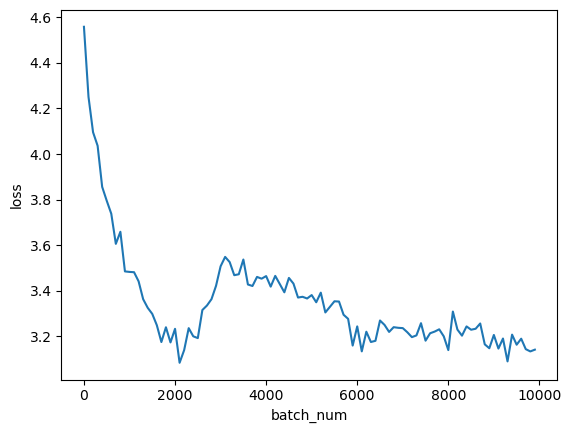

In [25]:
with open('loss.txt','r',encoding='utf-8') as f:
    data=f.read()
data=eval(data)
fig=plt.figure()
plt.plot([i*100 for i in range(len(data))],data)
plt.xlabel('batch_num')
plt.ylabel('loss')
fig.show()

## 20 加载之前的模型

In [26]:
# en_path = r'H:\datasets\data\翻译1\test.en.txt'
# ch_path = r'H:\datasets\data\翻译1\test.ch.txt'
# tokenizer = Tokenizer(en_path, ch_path, count_min=1)

In [27]:
# 数据评估
def eval1():
    device='cuda'
    model1 = Transformer(tokenizer)
    model1.load_state_dict(torch.load(f'./model/translation_25.pt'))
    model1 = model1.to(device)
    model1.eval()
    all_=[]
    for i in range(100):
        random_integers = range(len(tokenizer.test))[i*10:i*10+10]  # 评估
        end=compute_bleu4(tokenizer, random_integers, model1, device)
        if end==0:
            continue
        all_.append(end)
    print(sum(all_)/len(all_)) # 输出bleu4得分

In [28]:
eval1()

FileNotFoundError: [Errno 2] No such file or directory: './model/translation_25.pt'